# Classificação de Qualidade de Vinhos

Com objetivo de estudo de machine learning e também para praticar as funções "Pipeline" e "ColumnTransformer" do sklearn, baixei o dataset do kaggle(https://www.kaggle.com/datasets/shelvigarg/wine-quality-dataset/data) e fiz um todo uma análise e classificação da qualidade do vinho. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import confusion_matrix

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

%matplotlib inline

## Exportando e Conhecendo os Dados

<b>Variáveis do dataset</b>

<b>-type:</b> Tipo de vinho (branco ou vermelho)</b>

<b>-fixed acidity:</b> Ácido fixo

<b>-volatile acidity:</b> Ácido Volátil

<b>-citric acid:</b> Ácido Cítrico

<b>-residual sugar:</b> Resíduo de açucar no vinho

<b>-chlorides:</b> Concentração de cloreto 

<b>-free sulfur dioxide:</b> Dióxido de enxofre livre

<b>-total sulfur dioxide:</b> Dióxido de enxofre total

<b>-density:</b> Densidade

<b>-pH:</b> Ácidez vinho

<b>-sulphates:</b> Sulfatos

<b>-alcohol:</b> Porcentagem de álcool no vinho

<b>-quality:</b> Qualidade do Vinho


In [2]:
df_wine = pd.read_csv('winequalityN.csv')
df_wine.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [3]:
# Informações dataset
df_wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6487 non-null   float64
 2   volatile acidity      6489 non-null   float64
 3   citric acid           6494 non-null   float64
 4   residual sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


In [4]:
# Separando em treino e teste
x_train, x_test, y_train, y_test = train_test_split(df_wine.drop(['quality'], axis=1),
                                                    df_wine['quality'],
                                                    train_size=0.8,
                                                    random_state=14)

In [5]:
# Separando dados categórico e dados númericos 
x_train_cat = x_train['type']
x_train_num = x_train.drop(['type'], axis=1)

In [6]:
# Nome colunas
cat_name = [x_train_cat.name]
num_name = x_train_num.columns

## Análise Exploratória

<Figure size 1000x1000 with 0 Axes>

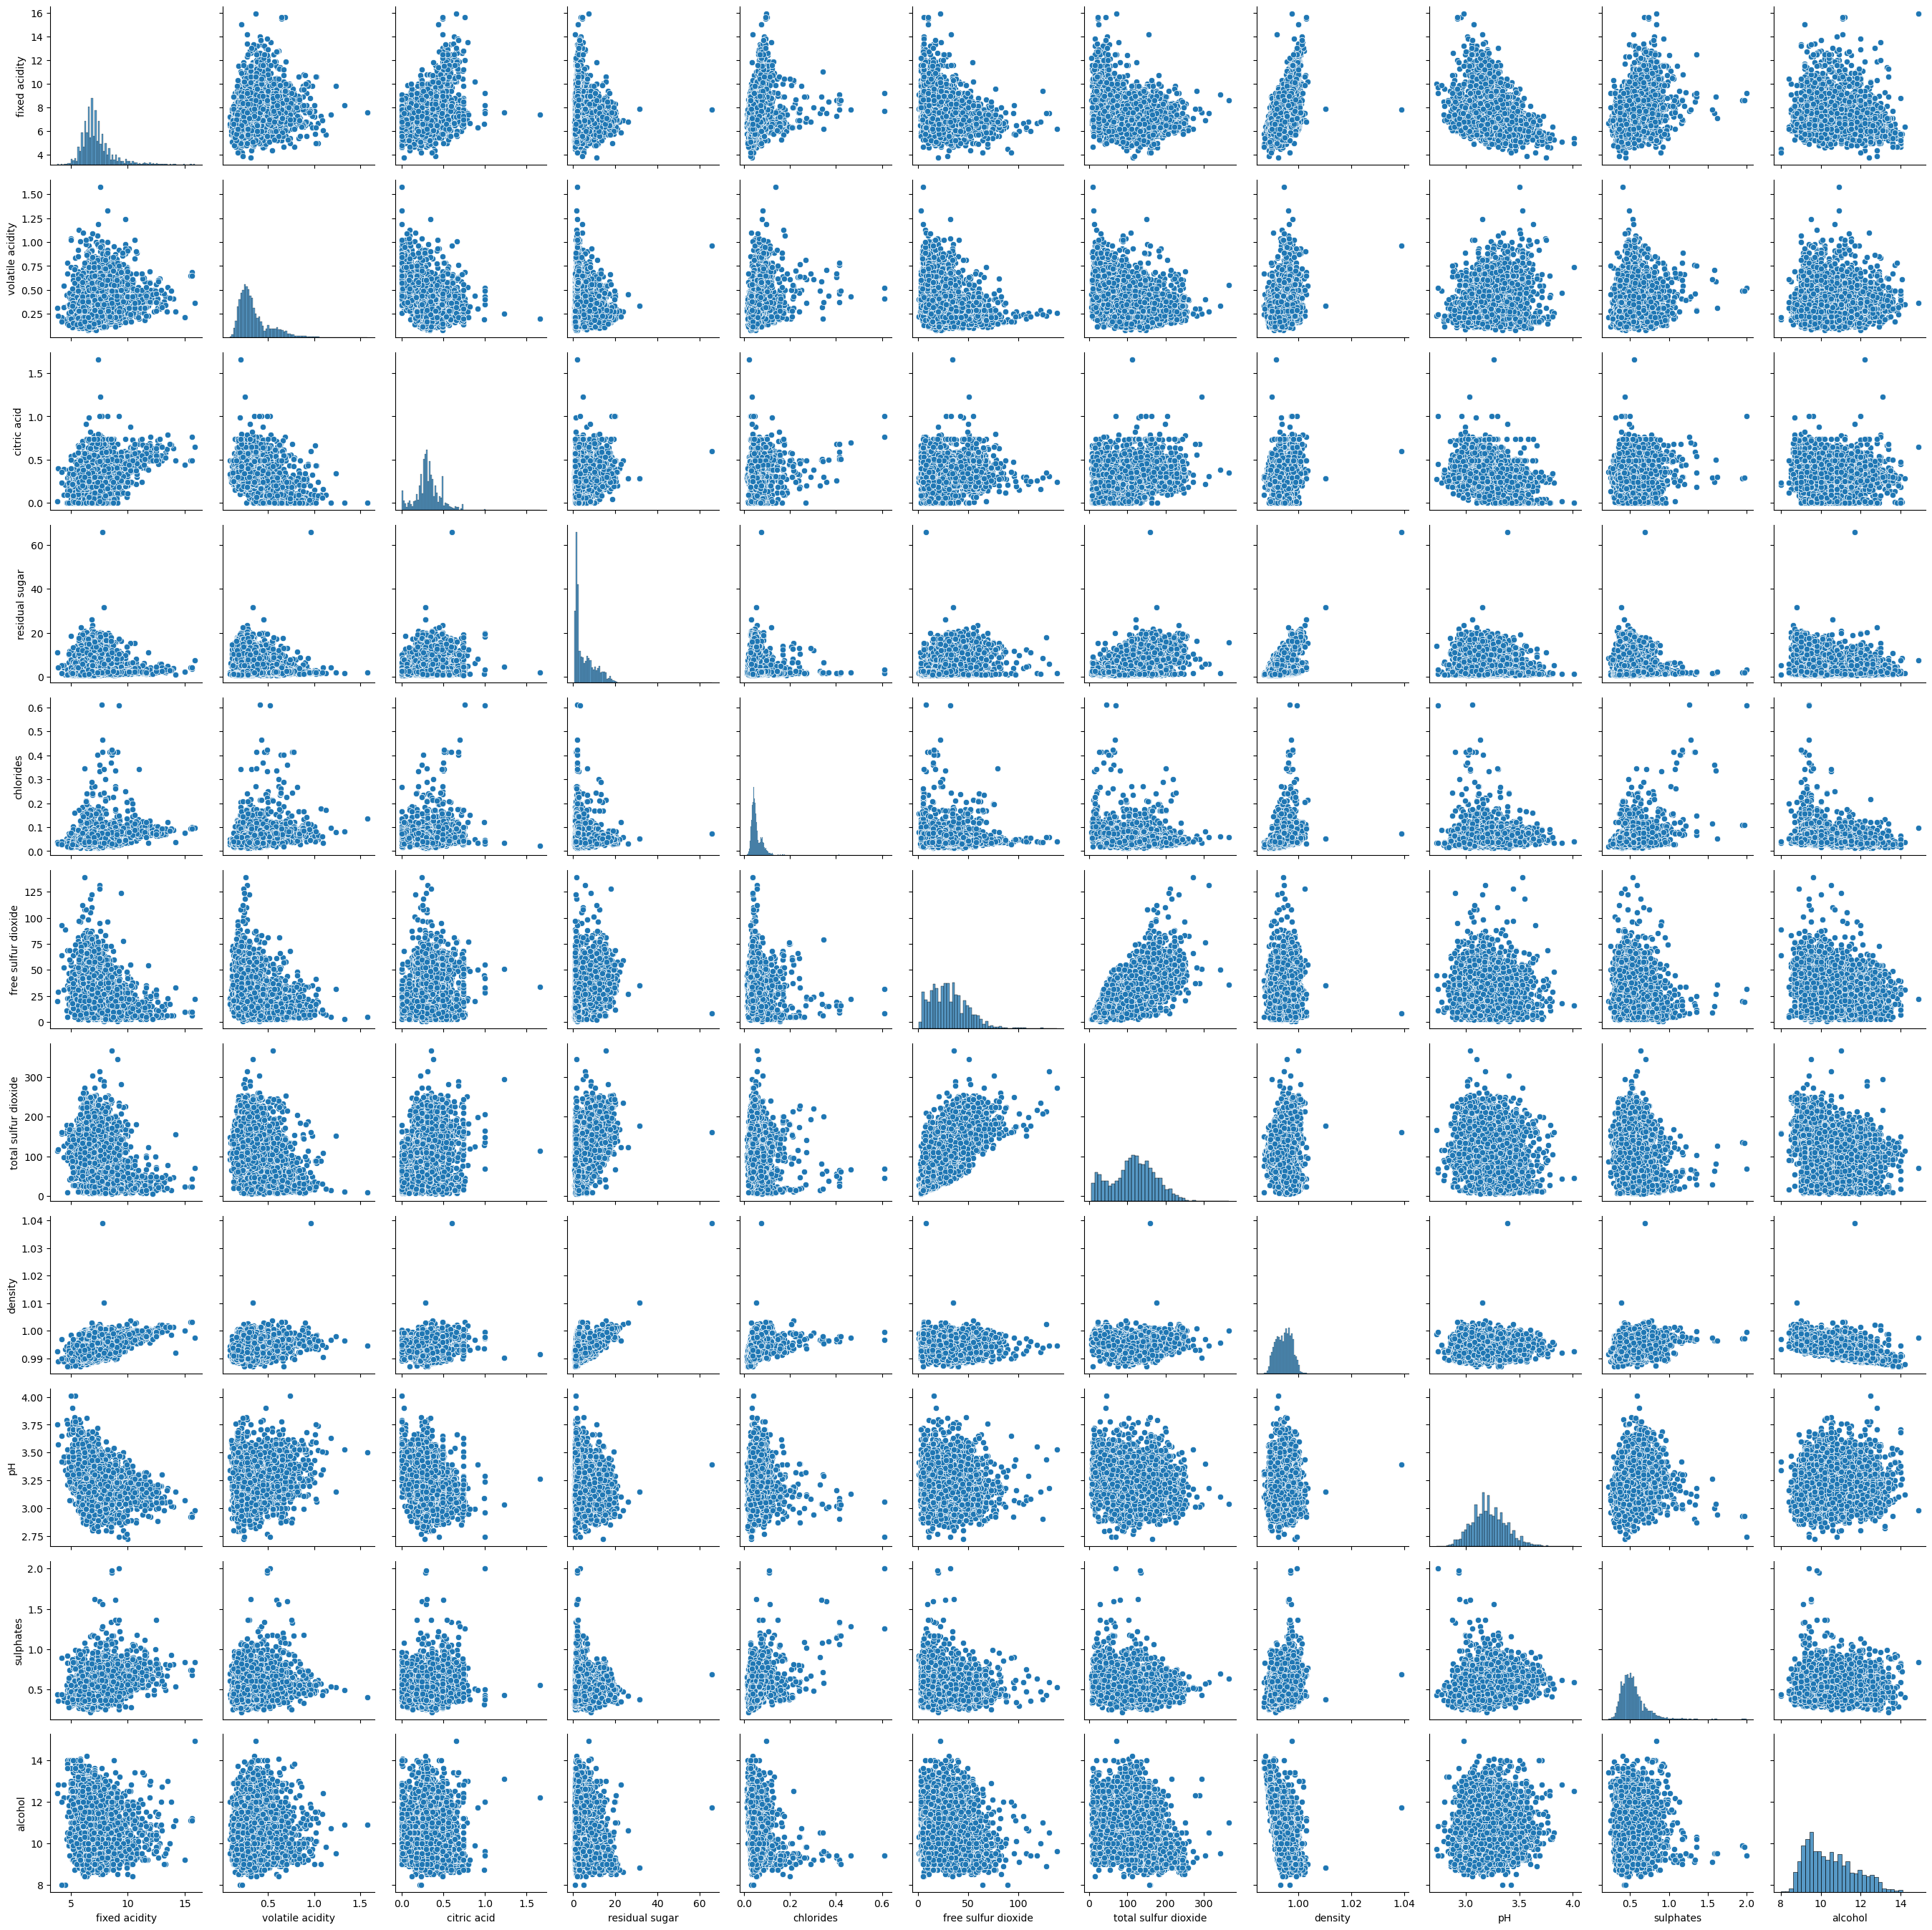

In [7]:
# Matrix Gráficos
plt.figure(figsize=(10, 10))
graf = sns.PairGrid(x_train_num)
graf.map_diag(sns.histplot)
graf.map_offdiag(sns.scatterplot);

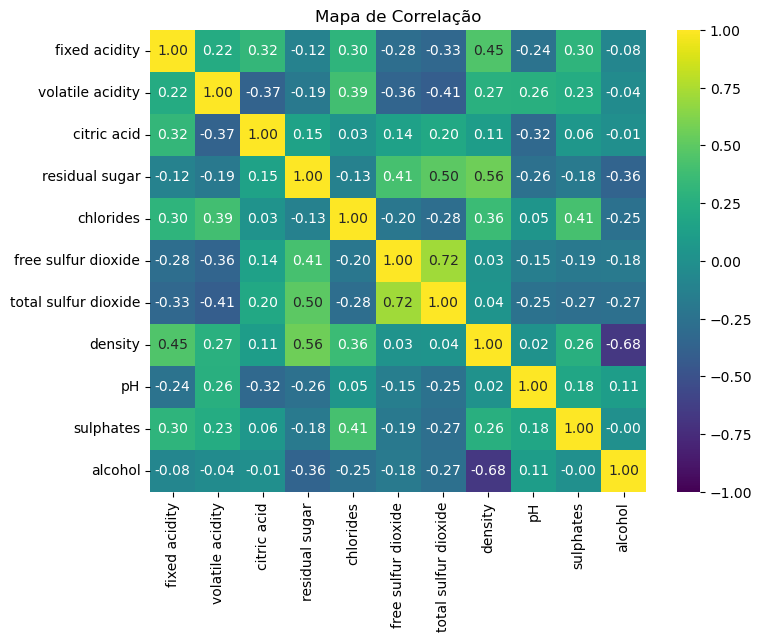

In [8]:
# Mapa de calor de Correlação entre variáveis preditivas
plt.figure(figsize=(8, 6))
plt.title('Mapa de Correlação')
sns.heatmap(x_train_num.corr(numeric_only=True), vmin=-1, vmax=1, annot=True, fmt='.2f', cmap='viridis');

In [9]:
# Valores missing
x_train_num.isna().sum()

fixed acidity           9
volatile acidity        5
citric acid             3
residual sugar          2
chlorides               1
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      7
sulphates               3
alcohol                 0
dtype: int64

<Axes: >

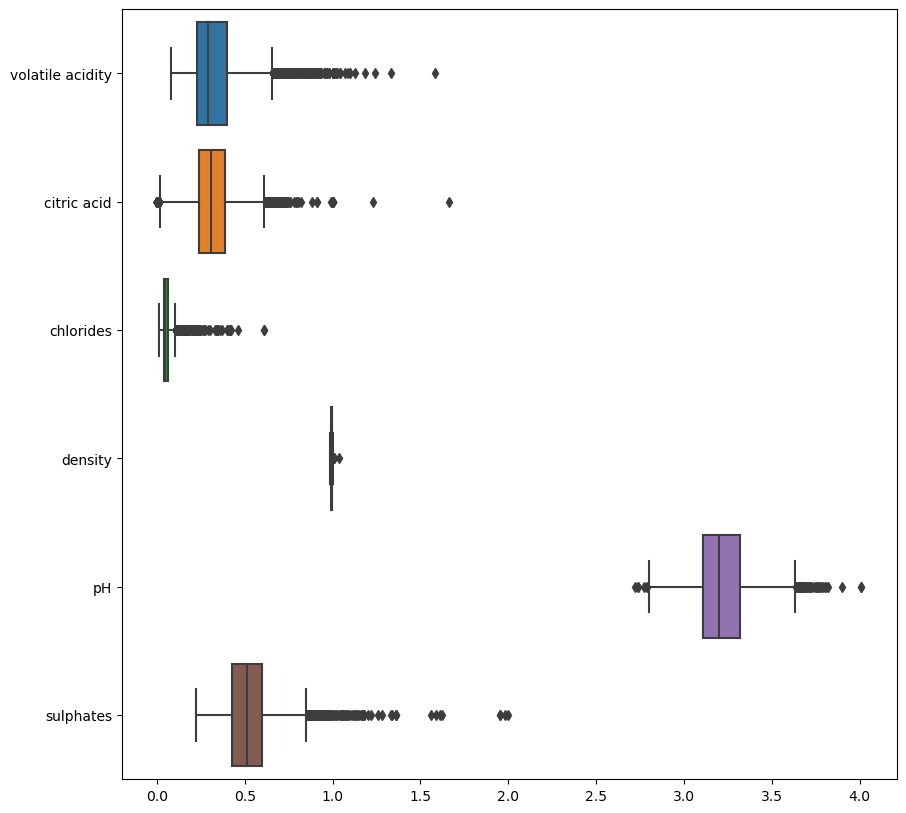

In [10]:
# Boxplot
var_list_maiores = ['free sulfur dioxide', 'total sulfur dioxide']
var_list_medianos = ['residual sugar', 'fixed acidity', 'alcohol']
plt.figure(figsize=(10,10))
sns.boxplot(data=x_train_num.drop(var_list_maiores + var_list_medianos, axis=1), orient='h')

<Axes: >

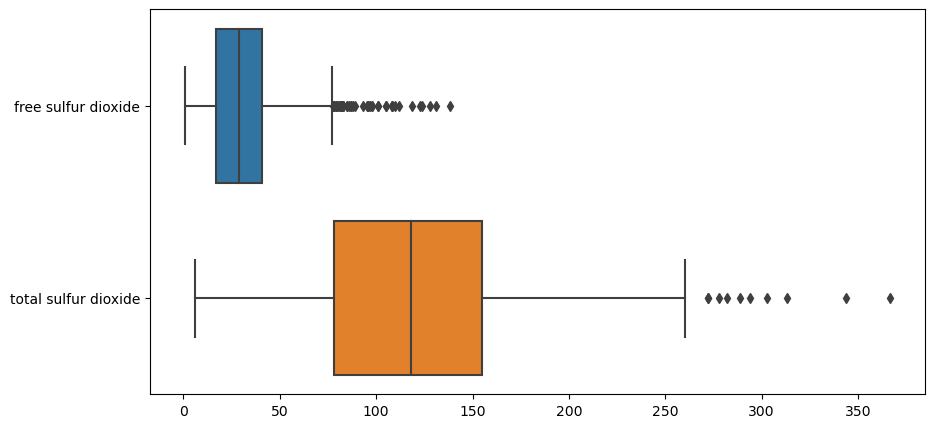

In [11]:
# Boxplot
plt.figure(figsize=(10,5))
sns.boxplot(data=x_train_num[var_list_maiores], orient='h')

<Axes: >

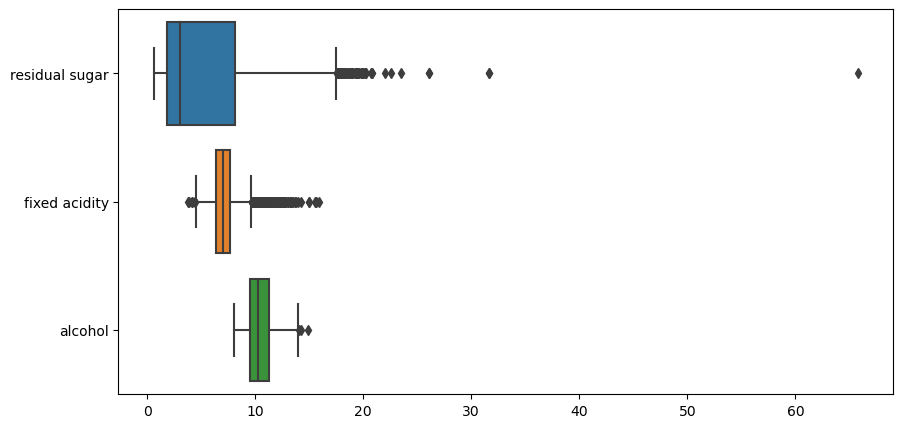

In [12]:
# Boxplot
plt.figure(figsize=(10,5))
sns.boxplot(data=x_train_num[var_list_medianos], orient='h')

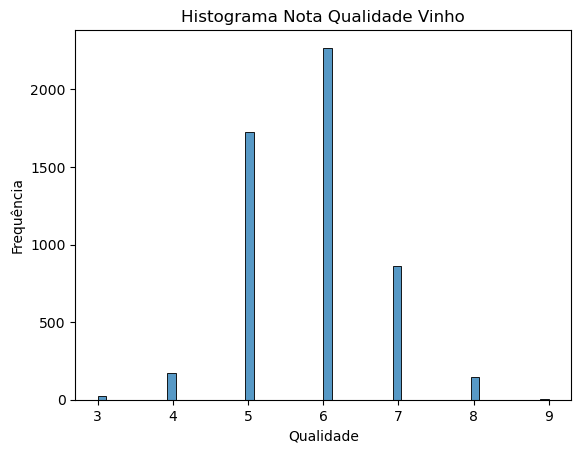

In [13]:
# Gráfico variável Y (Qualidade)
sns.histplot(y_train)
plt.title('Histograma Nota Qualidade Vinho')
plt.xlabel('Qualidade')
plt.ylabel('Frequência');

### Tratamento dados

In [14]:
# Pipeline categórica
pipe_cat = Pipeline([('dummies', ce.TargetEncoder()),
                      ('scaler', StandardScaler()),
                   ('imputer', SimpleImputer(strategy='most_frequent'))])

# Pipeline Númerica
pipe_num = Pipeline([('imputer', SimpleImputer(strategy='median')),
                    ('scaler', StandardScaler())])

# Transformação colunas
transformer = ColumnTransformer([('categorica', pipe_cat, cat_name),
                                 ('numerica', pipe_num, num_name)])
                                 

In [15]:
# Divisão dos dados em treino e validação
x_train_2, x_val, y_train_2, y_val = train_test_split(x_train, y_train, random_state=14)

In [16]:
# Treinamento e transformação dos dados de treinamento
x_train_trans = transformer.fit_transform(x_train_2, y_train_2)

# Transformação dados de validação
x_val_trans = transformer.transform(x_val)

## Modelos de Machine Learning

### Regressão logística

In [17]:
# Regressão Logística
rl_model = LogisticRegression(max_iter=250)

# Treinamento
rl_model.fit(x_train_trans, y_train_2)

# Previsão dos valores de y
y_rl = rl_model.predict(x_val_trans)

# Métricas
print(classification_report(y_val, y_rl, zero_division=0.0))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         5
           4       1.00      0.02      0.04        48
           5       0.60      0.63      0.62       436
           6       0.54      0.71      0.61       566
           7       0.56      0.26      0.35       214
           8       0.00      0.00      0.00        31

    accuracy                           0.56      1300
   macro avg       0.45      0.27      0.27      1300
weighted avg       0.57      0.56      0.53      1300



### Random Forest

In [18]:
# Random Forest
rf_model = RandomForestClassifier()

# Treinamento
rf_model.fit(x_train_trans, y_train_2)

# Previsão dos valores de y
y_rf = rf_model.predict(x_val_trans)

# Métricas
print(classification_report(y_val, y_rf, zero_division=0.0))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         5
           4       0.89      0.17      0.28        48
           5       0.70      0.73      0.71       436
           6       0.63      0.74      0.68       566
           7       0.62      0.44      0.52       214
           8       0.82      0.29      0.43        31

    accuracy                           0.65      1300
   macro avg       0.61      0.40      0.44      1300
weighted avg       0.66      0.65      0.64      1300



### Gradient Boosting 

In [19]:
# Gradiente Boosting
gb_model = GradientBoostingClassifier()

# Treinamento
gb_model.fit(x_train_trans, y_train_2)

# Previsão dos valores de y
y_gb = gb_model.predict(x_val_trans)

# Métricas
print(classification_report(y_val, y_gb, zero_division=0.0))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         5
           4       0.33      0.04      0.07        48
           5       0.65      0.66      0.65       436
           6       0.57      0.72      0.64       566
           7       0.53      0.29      0.38       214
           8       0.53      0.29      0.38        31

    accuracy                           0.59      1300
   macro avg       0.43      0.33      0.35      1300
weighted avg       0.58      0.59      0.57      1300



### Seleção Variável

In [21]:
for i in range(2,13,2):
    
    # Instânciando SelectKBest
    bestk = SelectKBest(score_func=f_classif, k=i)
    
    # Treinamento
    bestk.fit(x_train_trans, y_train_2)
    
    # Novos dataframes de treinamento e validação com melhores k
    train_df = pd.DataFrame(x_train_trans).loc[: , bestk.get_support()]
    val_df = pd.DataFrame(x_val_trans).loc[: , bestk.get_support()]
    
    # Random Forest
    rf_model = RandomForestClassifier()

    # Treinamento Random Forest
    rf_model.fit(train_df, y_train_2)

    # Previsão dos valores de y
    y_rf = rf_model.predict(val_df)
    
    # Acuracia
    acc_score = accuracy_score(y_val, y_rf)
    
    print(f'acúracia de {round(acc_score*100, 2)}% com valor de k={i}')

acúracia de 50.0% com valor de k=2
acúracia de 62.38% com valor de k=4
acúracia de 63.85% com valor de k=6
acúracia de 64.54% com valor de k=8
acúracia de 65.62% com valor de k=10
acúracia de 65.23% com valor de k=12


In [22]:
for i in range(2,13,2):
    
    # Instânciando SelectKBest
    bestk = SelectKBest(score_func=f_classif, k=i)
    
    # Treinamento
    bestk.fit(x_train_trans, y_train_2)
    
    # Novos dataframes de treinamento e validação com melhores k
    train_df = pd.DataFrame(x_train_trans).loc[: , bestk.get_support()]
    val_df = pd.DataFrame(x_val_trans).loc[: , bestk.get_support()]
    
    # GradientBoosting
    gb_model = GradientBoostingClassifier()

    # Treinamento Random Forest
    gb_model.fit(train_df, y_train_2)

    # Previsão dos valores de y
    y_gb = gb_model.predict(val_df)
    
    # Acuracia
    acc_score = accuracy_score(y_val, y_gb)
    
    print(f'acúracia de {round(acc_score*100, 2)}% com valor de k={i}')

acúracia de 54.54% com valor de k=2
acúracia de 56.23% com valor de k=4
acúracia de 58.08% com valor de k=6
acúracia de 58.77% com valor de k=8
acúracia de 59.31% com valor de k=10
acúracia de 59.08% com valor de k=12


### Melhores parâmetros

In [23]:
# Parâmetros
param_grid={'n_estimators': [10,50,100,150,250,500,1000,2000],
            'min_samples_split': [2,4,6,8,10],
            'criterion': ['gini', 'entropy', 'log_loss']}

# Modelo
rf_model = RandomForestClassifier()

# Grid Search
gs = GridSearchCV(rf_model, param_grid=param_grid, cv=3)

# Treinamento
gs.fit(x_train_trans, y_train_2)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'min_samples_split': [2, 4, 6, 8, 10],
                         'n_estimators': [10, 50, 100, 150, 250, 500, 1000,
                                          2000]})

In [24]:
# Melhores parâmetros
gs.best_params_

{'criterion': 'gini', 'min_samples_split': 2, 'n_estimators': 1000}

### Modelo final

In [25]:
# Treinamento e transformação dos dados de treinamento
x_train_final = transformer.fit_transform(x_train, y_train)

# Transformação dados de validação
x_test_final = transformer.transform(x_test)

In [28]:
# Modelo Final Random Forest
rf_model = RandomForestClassifier(n_estimators=1000, criterion='gini', min_samples_split=2, random_state=10)

# Treinamento
rf_model.fit(x_train_final, y_train)

# Previsão dos valores de y
y_rf = rf_model.predict(x_test_final)

# Métricas
print(classification_report(y_test, y_rf, zero_division=0.0))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         7
           4       0.86      0.14      0.24        44
           5       0.72      0.75      0.74       413
           6       0.67      0.79      0.73       567
           7       0.69      0.59      0.63       220
           8       1.00      0.36      0.53        47
           9       0.00      0.00      0.00         2

    accuracy                           0.70      1300
   macro avg       0.56      0.37      0.41      1300
weighted avg       0.71      0.70      0.68      1300



<Axes: >

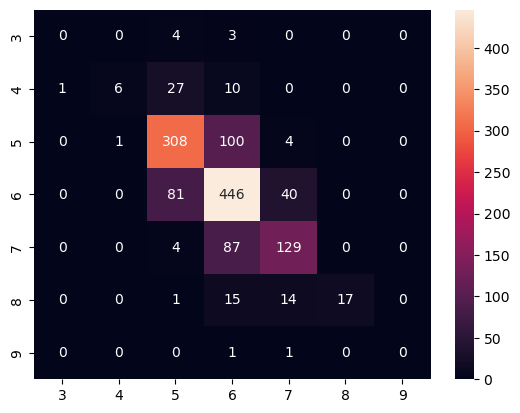

In [29]:
# Mapa de Calor
sns.heatmap(confusion_matrix(y_test, y_rf), annot=True, fmt='.0f', xticklabels=[3,4,5,6,7,8,9], yticklabels=[3,4,5,6,7,8,9])